In [1]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from tqdm.notebook import trange, tqdm

### USE FOR LOCAL JUPYTER NOTEBOOKS ###
DOWNLOAD_DIR = Path("../download")
DATA_DIR = Path("../data")
SUBMISSIONS_DIR = Path("../submissions")
MODEL_DIR = Path("../models")
#######################################

##### GOOGLE COLAB ######
# DOWNLOAD_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/earthquake_damage_competition/download')
# SUBMISSIONS_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/earthquake_damage_competition/submissions')
# DATA_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/earthquake_damage_competition/data')
# MODEL_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/earthquake_damage_competition/model')
########################

X = pd.read_csv(DOWNLOAD_DIR / "train_values.csv", index_col="building_id")
categorical_columns = X.select_dtypes(include="object").columns
bool_columns = [col for col in X.columns if col.startswith("has")]

X_test = pd.read_csv(DOWNLOAD_DIR / "test_values.csv", index_col="building_id")
y = pd.read_csv(DOWNLOAD_DIR / "train_labels.csv", index_col="building_id")

In [2]:
sns.set()

In [3]:
import wandb

wandb.login()

True

In [4]:
run = wandb.init(project="earthquake_damage_competition")

In [5]:
X_test.shape

(86868, 38)

In [6]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

label_enc = LabelEncoder()

t = [("ord_encoder", OrdinalEncoder(dtype=int), categorical_columns)]
ct = ColumnTransformer(transformers=t, remainder="passthrough")

In [7]:
X_all_ints = ct.fit_transform(X)
y = label_enc.fit_transform(np.ravel(y))

In [8]:
# Note that append for pandas objects works differently to append with
# python objects e.g. python append modifes the list in-place
# pandas append returns a new object, leaving the original unmodified
not_categorical_columns = X.select_dtypes(exclude="object").columns
cols_ordered_after_ordinal_encoding = categorical_columns.append(
    not_categorical_columns
)

In [9]:
geo_cols = pd.Index(["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"])
cat_cols_plus_geo = categorical_columns.append(geo_cols)

In [10]:
train_data = lgb.Dataset(
    X_all_ints,
    label=y,
    feature_name=list(cols_ordered_after_ordinal_encoding),
    categorical_feature=list(cat_cols_plus_geo),
)

In [11]:
# Taken from the docs for lgb.train and lgb.cv
# Helpful Stackoverflow answer:
# https://stackoverflow.com/questions/50931168/f1-score-metric-in-lightgbm
from sklearn.metrics import f1_score


def get_ith_pred(preds, i, num_data, num_class):
    """
    preds: 1D NumPY array
        A 1D numpy array containing predicted probabilities. Has shape
        (num_data * num_class,). So, For binary classification with
        100 rows of data in your training set, preds is shape (200,),
        i.e. (100 * 2,).
    i: int
        The row/sample in your training data you wish to calculate
        the prediction for.
    num_data: int
        The number of rows/samples in your training data
    num_class: int
        The number of classes in your classification task.
        Must be greater than 2.


    LightGBM docs tell us that to get the probability of class 0 for
    the 5th row of the dataset we do preds[0 * num_data + 5].
    For class 1 prediction of 7th row, do preds[1 * num_data + 7].

    sklearn's f1_score(y_true, y_pred) expects y_pred to be of the form
    [0, 1, 1, 1, 1, 0...] and not probabilities.

    This function translates preds into the form sklearn's f1_score
    understands.
    """
    # Does not work for binary classification, preds has a different form
    # in that case
    assert num_class > 2

    preds_for_ith_row = [
        preds[class_label * num_data + i] for class_label in range(num_class)
    ]

    # The element with the highest probability is predicted
    return np.argmax(preds_for_ith_row)


def lgb_f1_micro(preds, train_data):
    y_true = train_data.get_label()

    num_data = len(y_true)
    num_class = 3

    y_pred = []
    for i in range(num_data):
        ith_pred = get_ith_pred(preds, i, num_data, num_class)
        y_pred.append(ith_pred)

    return "f1", f1_score(y_true, y_pred, average="micro"), True

In [12]:
param = {
    "num_leaves": 120,
    "min_child_samples": 40,
    "learning_rate": 0.1,
    "boosting_type": "goss",
    "objective": "multiclassova",
    "is_unbalance": True,
    "metric": ["multiclassova", "multi_error"],
    "num_class": 3,
    "verbosity": -1,
    "num_threads": 8,
    "seed": 1,
}

run = wandb.init(project="earthquake_damage_competition", config=param)

In [13]:
wandb.config

{'num_leaves': 120, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'goss', 'objective': 'multiclassova', 'is_unbalance': True, 'metric': ['multiclassova', 'multi_error'], 'num_class': 3, 'verbosity': -1, 'num_threads': 8, 'seed': 1}

In [14]:
wandb.config

{'num_leaves': 120, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'goss', 'objective': 'multiclassova', 'is_unbalance': True, 'metric': ['multiclassova', 'multi_error'], 'num_class': 3, 'verbosity': -1, 'num_threads': 8, 'seed': 1}

In [15]:
run.config

{'num_leaves': 120, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'goss', 'objective': 'multiclassova', 'is_unbalance': True, 'metric': ['multiclassova', 'multi_error'], 'num_class': 3, 'verbosity': -1, 'num_threads': 8, 'seed': 1}

In [16]:
from wandb.lightgbm import wandb_callback

evals_result = {}
booster = lgb.train(
    wandb.config,
    train_data,
    100,
    # You can include train_data in the valid_set to easily
    # make plots of the loss functions
    valid_sets=[train_data, val_data],
    valid_names=["train", "val"],
    evals_result=evals_result,
    early_stopping_rounds=None,
    categorical_feature=list(cat_cols_plus_geo),
    feval=lgb_f1_micro,
    callbacks=[wandb_callback()],
)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_all_ints, y, test_size=0.25, random_state=42, stratify=y
)

full_train_data = lgb.Dataset(
    X_all_ints,
    label=y,
    feature_name=list(cols_ordered_after_ordinal_encoding),
    categorical_feature=list(cat_cols_plus_geo),
    free_raw_data=False,
)

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    feature_name=list(cols_ordered_after_ordinal_encoding),
    categorical_feature=list(cat_cols_plus_geo),
    free_raw_data=False,
)

val_data = lgb.Dataset(
    X_val,
    label=y_val,
    feature_name=list(cols_ordered_after_ordinal_encoding),
    categorical_feature=list(cat_cols_plus_geo),
    free_raw_data=False,
)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_all_ints, y, test_size=0.25, random_state=42, stratify=y
)

full_train_data = lgb.Dataset(
    X_all_ints,
    label=y,
    feature_name=list(cols_ordered_after_ordinal_encoding),
    categorical_feature=list(cat_cols_plus_geo),
    free_raw_data=False,
)

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    feature_name=list(cols_ordered_after_ordinal_encoding),
    categorical_feature=list(cat_cols_plus_geo),
    free_raw_data=False,
)

val_data = lgb.Dataset(
    X_val,
    label=y_val,
    feature_name=list(cols_ordered_after_ordinal_encoding),
    categorical_feature=list(cat_cols_plus_geo),
    free_raw_data=False,
)

In [19]:
param = {
    "num_leaves": 120,
    "min_child_samples": 40,
    "learning_rate": 0.1,
    "boosting_type": "goss",
    "objective": "multiclassova",
    "is_unbalance": True,
    "metric": ["multiclassova", "multi_error"],
    "num_class": 3,
    "verbosity": -1,
    "num_threads": 8,
    "seed": 1,
}

run = wandb.init(project="earthquake_damage_competition", config=param)

In [20]:
from wandb.lightgbm import wandb_callback

evals_result = {}
booster = lgb.train(
    wandb.config,
    train_data,
    100,
    # You can include train_data in the valid_set to easily
    # make plots of the loss functions
    valid_sets=[train_data, val_data],
    valid_names=["train", "val"],
    evals_result=evals_result,
    early_stopping_rounds=None,
    categorical_feature=list(cat_cols_plus_geo),
    feval=lgb_f1_micro,
    callbacks=[wandb_callback()],
)

In [21]:
wandb.config

{'num_leaves': 120, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'goss', 'objective': 'multiclassova', 'is_unbalance': True, 'metric': ['multiclassova', 'multi_error'], 'num_class': 3, 'verbosity': -1, 'num_threads': 8, 'seed': 1}

In [22]:
wandb.config == param

False

In [23]:
wandb.config

{'num_leaves': 120, 'min_child_samples': 40, 'learning_rate': 0.1, 'boosting_type': 'goss', 'objective': 'multiclassova', 'is_unbalance': True, 'metric': ['multiclassova', 'multi_error'], 'num_class': 3, 'verbosity': -1, 'num_threads': 8, 'seed': 1}

In [24]:
from pprint import pprint

pprint(wandb.config)
pprint(param)

In [25]:
from wandb.lightgbm import wandb_callback

evals_result = {}
booster = lgb.train(
    param,
    train_data,
    100,
    # You can include train_data in the valid_set to easily
    # make plots of the loss functions
    valid_sets=[train_data, val_data],
    valid_names=["train", "val"],
    evals_result=evals_result,
    early_stopping_rounds=None,
    categorical_feature=list(cat_cols_plus_geo),
    feval=lgb_f1_micro,
    callbacks=[wandb_callback()],
)

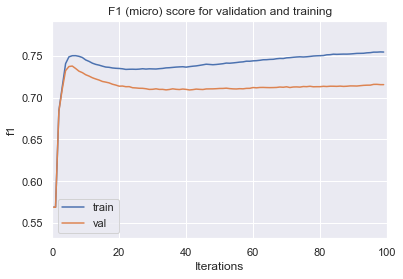

In [26]:
f1_plot = lgb.plot_metric(
    evals_result, metric="f1", title="F1 (micro) score for validation and training"
)
wandb.log({"f1_score plot": wandb.Image(f1_plot)})
plt.show()

In [27]:
log_loss_plot = lgb.plot_metric(
    evals_result,
    metric="multi_logloss",
    title="Multi Log Loss for validation and training",
)
wandb.log({"multi logloss plot": wandb.Image(log_loss_plot)})

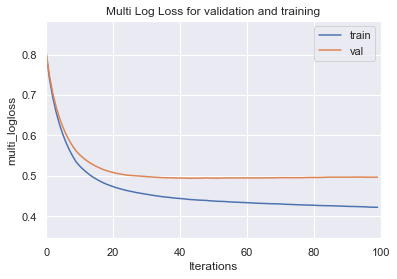

In [28]:
multierror_plot = lgb.plot_metric(
    evals_result, metric="multi_error", title="Multi Error for validation and training"
)
wandb.log({"multi error plot": wandb.Image(multierror_plot)})

wandb.sdk.wandb_config.Config

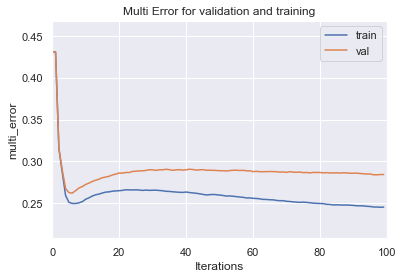

In [29]:
type(wandb.config)

In [30]:
type(run.config)

wandb.sdk.wandb_config.Config

In [31]:
type(param)

dict

In [32]:
dict(wandb.config)

{'num_leaves': 120,
 'min_child_samples': 40,
 'learning_rate': 0.1,
 'boosting_type': 'goss',
 'objective': 'multiclassova',
 'is_unbalance': True,
 'metric': ['multiclassova', 'multi_error'],
 'num_class': 3,
 'verbosity': -1,
 'num_threads': 8,
 'seed': 1}

In [33]:
param = {
    "num_leaves": 120,
    "min_child_samples": 40,
    "learning_rate": 0.05,
    "num_boost_round": 50,
    "early_stopping_round": 5,
    "boosting_type": "goss",
    "objective": "multiclassova",
    "is_unbalance": True,
    "metric": ["multiclassova", "multi_error"],
    "num_class": 3,
    "verbosity": -1,
    "num_threads": 8,
    "seed": 1,
}

run = wandb.init(project="earthquake_damage_competition", config=param)